In [1]:
import navis
import neuron

import navis.interfaces.neuron as nrn

In [2]:
# Load one of the example neurons (a Drosophila projection neuron from the hemibrain connectome)
# Note the conversion to microns!
n = navis.example_neurons(1).convert_units('um')

# Here we manually corrected the soma 
n.soma = 20

# Reroot to the soma 
n.reroot(n.soma, inplace=True)

# Create the compartment model
cmp = nrn.CompartmentModel(n, res=10)

In [3]:
# Set the specific axial resistivity for the entire neuron in Ohm cm
cmp.Ra = 266.1

# Set the specific membran capacitance in mF / cm**2
cmp.cm = 0.8

# Add passive membran properties for the entire neuron
cmp.insert('pas',
           g=1/20800,  # specific leakage conductance = 1/Rm; Rm = specific membran resistance in Ohm cm**2
           e=-60,      # leakage reverse potential
           )

In [4]:
# Label axon/dendrite
navis.split_axon_dendrite(n, label_only=True, cellbodyfiber='soma')

n.nodes.head()

,node_id,label,x,y,z,radius,parent_id,type,compartment
0,1,0,126.272003,298.000000,224.496017,0.080000,2,end,cellbodyfiber
1,2,0,126.112007,297.840027,224.656006,0.146274,3,slab,cellbodyfiber
2,3,0,125.952003,297.520020,224.976013,0.277771,4,slab,cellbodyfiber
3,4,0,125.952003,297.200012,225.616013,0.277771,5,slab,cellbodyfiber
4,5,0,125.632004,297.040009,225.936005,0.277771,6,slab,cellbodyfiber


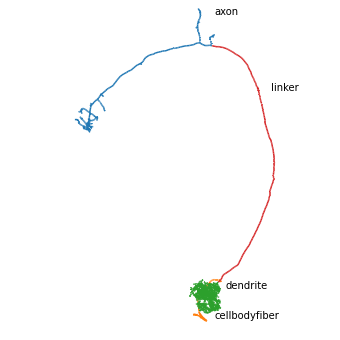

In [5]:
# A quick visualization
fig, ax = navis.plot2d(n, color_by='compartment', palette='tab10', lw=1.5)

# Label compartments 
import seaborn as sns
for l in n.nodes.compartment.unique():
    loc = n.nodes.loc[n.nodes.compartment == l, ['x', 'y', 'z']].values[-1]
    ax.text(loc[0] + 10, loc[1], loc[2], l)    

ax.elev = -110

In [6]:
# Collect axon nodes
axon_nodes = n.nodes.loc[n.nodes.compartment.isin(['axon', 'linker']), 'node_id'].values

# Get the sections for the given nodes
axon_secs = list(set(cmp.get_node_section(axon_nodes)))

# Insert HH mechanism at the given sections
cmp.insert('hh', subset=axon_secs)

In [7]:
# Recordings and stimulations work via segments (as opposed to sections for mechanisms)
# Hence we can use node IDs directly here

# Let's determine the tip of the axon and base of the dendrites programmatically using the 
# geodesic distance
dists = navis.geodesic_matrix(n, node_ids=n.soma)

# Sort by distance from soma 
dists = dists.iloc[0].sort_values()

dists.head(10)

20      0.000000
21      0.455753
19      0.633259
2409    0.836538
22      1.095767
18      1.113258
23      1.415775
2410    1.474030
24      1.692905
17      2.032377
Name: 20, dtype: float64

In [8]:
# Find the closest "dendrite" and the most distal "axon" node
dend = n.nodes[n.nodes.compartment == 'dendrite'].node_id.values
dend_base = dists.index[dists.index.isin(dend)][0]
print(f'Node at the base of the dendrites: {dend_base}')

axo = n.nodes[n.nodes.compartment == 'axon'].node_id.values
axo_tip = dists.index[dists.index.isin(axo)][-1]
print(f'Node at the tip of the axon: {axo_tip}')

Node at the base of the dendrites: 467
Node at the tip of the axon: 4384


In [9]:
# Add voltage recordings
cmp.add_voltage_record(dend_base, label='dendrite_base')
cmp.add_voltage_record(axo_tip, label='axon_tip')
cmp.add_voltage_record(n.soma, label='soma')

In [10]:
# Get dendritic postsynapses 
post = n.postsynapses[n.postsynapses.compartment == 'dendrite']
post.head()

,connector_id,node_id,type,x,y,z,roi,confidence,compartment
137,137,3736,post,135.232,291.104,210.840,AL(R),0.906454,dendrite
138,138,635,post,132.872,284.448,196.056,AL(R),0.928960,dendrite
139,139,4124,post,131.432,277.048,200.960,AL(R),0.605084,dendrite
140,140,3176,post,124.984,286.568,216.480,AL(R),0.922643,dendrite
219,219,3061,post,128.312,276.848,217.272,AL(R),0.981077,dendrite


In [11]:
# Here we will open successively more synapses over 5 stimulations
for i in range(5):    
    # Onset for this stimulation
    start = 50 + i * 200
    # Number of synapses to activate
    n_syn = i * 5
    cmp.add_synaptic_current(where=post.node_id.unique()[0:n_syn],
                             start=start,
                             max_syn_cond=.1,
                             rev_pot=-10)

In [12]:
# Now we can run our simulation for 1s
# This is equivalent to neuron.h.finitialize + neuron.h.continuerun
cmp.run_simulation(1000, v_init=-60)

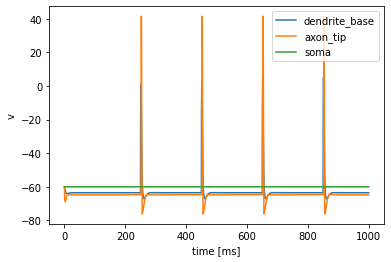

In [13]:
# Plot the results
axes = cmp.plot_results()

(240.0, 280.0)

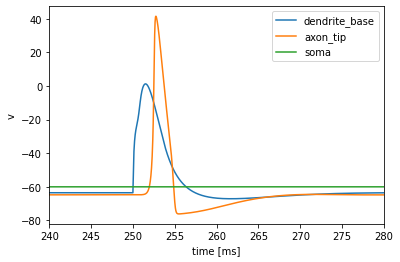

In [14]:
# Plot again and zoom in on one spike
axes = cmp.plot_results()

axes[0].set_xlim(240, 280)

In [15]:
cmp.records

{'v': {'dendrite_base': Vector[0], 'axon_tip': Vector[1], 'soma': Vector[2]}}

In [16]:
cmp.records['v']['dendrite_base'].as_numpy()

array([-60.        , -60.04157854, -60.07494932, ..., -63.52188478,
       -63.52188478, -63.52188478])

In [17]:
# First we need to reset our model (by re-assigning `cmp` the old model will be garbage-collected)
cmp = nrn.CompartmentModel(n, res=10)

# Set properties and mechanisms
cmp.Ra, cmp.cm = 266.1, 0.8
cmp.insert('pas', g=1/20800, e=-60)
axon_secs = list(set(cmp.get_node_section(axon_nodes)))
cmp.insert('hh', subset=axon_secs)

# Add recording
cmp.add_voltage_record(dend_base, label='dendrite_base')
cmp.add_voltage_record(axo_tip, label='axon_tip')
cmp.add_voltage_record(n.soma, label='soma')

# Also add a spike counter at the axon 
cmp.add_spike_detector(axo_tip, label='axon_tip')

# Now add a noisy preinput to say 20 dendritic postsynapses
post = n.connectors[(n.connectors.compartment == 'dendrite') & (n.connectors.type == 'post')]
cmp.add_synaptic_input(post.node_id.unique()[0:20],
                       spike_no=20,  # produce 20 presynaptic spikes 
                       spike_int=50, # with an average interval of 50ms: 20 * 50ms = over 1s
                       spike_noise=1, # very noisy!
                       cn_weight=0.04)
# Run for 1s
cmp.run_simulation(1000, v_init=-60)

Text(0, 0.5, 'spikes [Hz]')

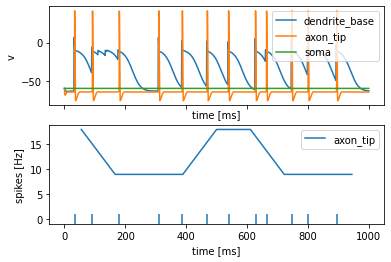

In [21]:
# Plot results
axes = cmp.plot_results()

axes[1].set_ylabel('spikes [Hz]')

In [ ]:
cmp.add_synaptic_input?

Signature:
cmp.add_synaptic_input(
    where,
    start=5,
    spike_no=1,
    spike_int=10,
    spike_noise=0,
    syn_tau1=0.1,
    syn_tau2=10,
    syn_rev_pot=0,
    cn_thresh=10,
    cn_delay=1,
    cn_weight=0,
)
Docstring:
Add synaptic input to model.

This uses the Exp2Syn synapse. All targets in `where` are triggered
by the same NetStim - i.e. they will all receive their spike(s) at the
same time.

Parameters
----------
where :         int | list of int
                Node IDs at which to simulate synaptic input.

Properties for presynaptic spikes:

start :         int
                Onset [ms] of first spike from beginning of simulation.
spike_no :      int
                Number of presynaptic spikes to produce.
spike_int :     int
                Interval [ms] between consecutive spikes.
spike_noise :   float [0-1]
                Fractional randomness in spike timing.

Synapse properties:

syn_tau1 :      int
                Rise time constant [ms].
syn_tau2 :      int
 

In [42]:
# First create a small 3 way network where one of the neurons (B) is inhibitory
import pandas as pd 
edges = pd.DataFrame([])
edges['source'] = ['A', 'B']
edges['target'] = ['C', 'C']
edges['weight'] = [0.5, -1]
edges

,source,target,weight
0,A,C,0.5
1,B,C,-1.0


In [46]:
# Next initialize network from edge list 
net = nrn.PointNetwork.from_edge_list(edges, model='IntFire4')
net

PointNetwork<neurons=3,edges=2>

In [47]:
# Add the stimulus
net.add_stimulus('A', start=100, stop=1000, frequency=100, randomness=0)
net.add_stimulus('B', start=600, stop=800, frequency=100, randomness=0)

# Run simulation
net.run_simulation(1000)

(0.0, 1000.0)

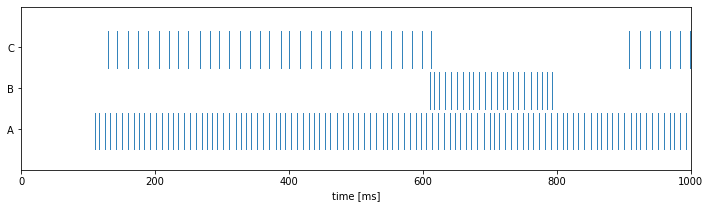

In [48]:
# Plot 
ax = net.plot_raster(backend='matplotlib', label=True)

ax.set_xlim(0, 1000)